In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import glob
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import roc_auc_score

os.environ["WANDB_SILENT"] = "true"

from owkin.training import train, RocLoss
from owkin.dataset import build_dataset
from owkin.models.mono_models import MLP, SVM
from owkin.models.aggregators import SmoothMaxAggregator, MaxAggregator

In [3]:
X_train, X_train_mean, y_train, X_val, X_val_mean, y_val, X_test, X_test_mean, df_test = build_dataset()

## TODO:

Look at each features and see if we can see cool things (e.g. maybe need to renormalize all of them)


## Observation:

- all the features are postive => normalisation ?

In [4]:
X_positive_train = X_train[y_train == 1]
X_negative_train = X_train[y_train == 0]

X_positive_train_mean = X_train_mean[y_train == 1]
X_negative_train_mean = X_train_mean[y_train == 0]

X_positive_val = X_val[y_val == 1]
X_negative_val = X_val[y_val == 0]

In [5]:
print("     train".ljust(15) + "val")
print(f"pos  {X_positive_train.shape[0]}".ljust(15) + f"{X_positive_val.shape[0]}")
print(f"neg  {X_negative_train.shape[0]}".ljust(15) + f"{X_negative_val.shape[0]}")
print(f"%pos {'{:.2f}'.format(X_positive_train.shape[0]/X_negative_train.shape[0])}".ljust(15) + f"{'{:.2f}'.format(X_positive_val.shape[0]/X_negative_val.shape[0])}")

     train     val
pos  106       22
neg  170       46
%pos 0.62      0.48


In [6]:
num_feature = X_train.shape[-1]

In [7]:
X_positive_train.shape

(106, 1000, 2048)

In [8]:
X_positive_train_flat = X_positive_train.reshape(-1, num_feature)
X_negative_train_flat = X_negative_train.reshape(-1, num_feature)

X_train_flat = X_train.reshape(-1, num_feature)

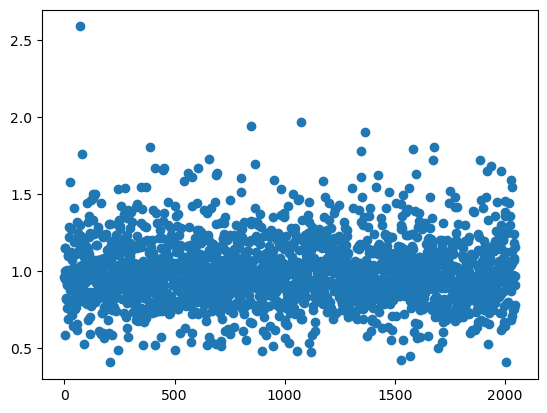

In [68]:
tab_mean_positive = np.zeros(num_feature)
tab_mean_negative = np.zeros(num_feature)
tab_mean_diff = np.zeros(num_feature)

tab_std_positive = np.zeros(num_feature)
tab_std_negative = np.zeros(num_feature)

for feature in range(num_feature):
    tab_mean_positive[feature] = X_positive_train_flat[:,feature].mean()
    tab_mean_negative[feature] = X_negative_train_flat[:,feature].mean()
    tab_mean_diff[feature] = tab_mean_positive[feature]/tab_mean_negative[feature]

    tab_std_positive[feature] = X_positive_train_flat[:,feature].std()
    tab_std_negative[feature] = X_negative_train_flat[:,feature].std()



plt.scatter(range(num_feature), tab_mean_diff)
plt.show()

In [69]:
tab_mean_diff.argmax()

72

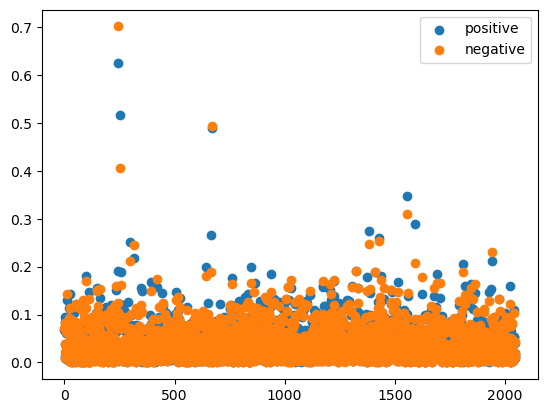

In [10]:
plt.scatter(range(num_feature), tab_mean_positive, label = "positive")
plt.scatter(range(num_feature), tab_mean_negative, label = "negative")
plt.legend()
plt.show()

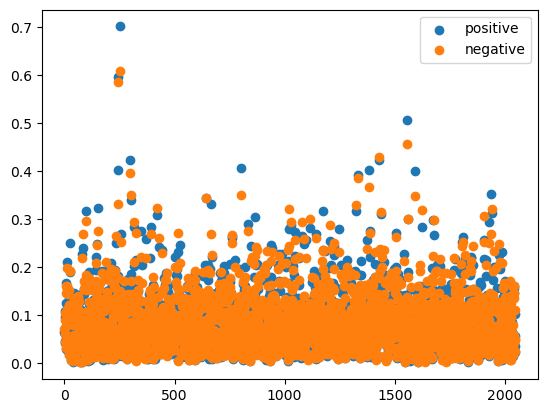

In [11]:
plt.scatter(range(num_feature), tab_std_positive, label = "positive")
plt.scatter(range(num_feature), tab_std_negative, label = "negative")
plt.legend()
plt.show()

In [101]:
X_positive_train_max = X_positive_train.max(axis=1)
X_negative_train_max = X_negative_train.max(axis=1)

X_positive_train_max_flat = X_positive_train_max.reshape(-1, num_feature)
X_negative_train_max_flat = X_negative_train_max.reshape(-1, num_feature)


X_positive_val_max = X_positive_val.max(axis=1)
X_negative_val_max = X_negative_val.max(axis=1)

X_positive_val_max_flat = X_positive_val_max.reshape(-1, num_feature)
X_negative_val_max_flat = X_negative_val_max.reshape(-1, num_feature)

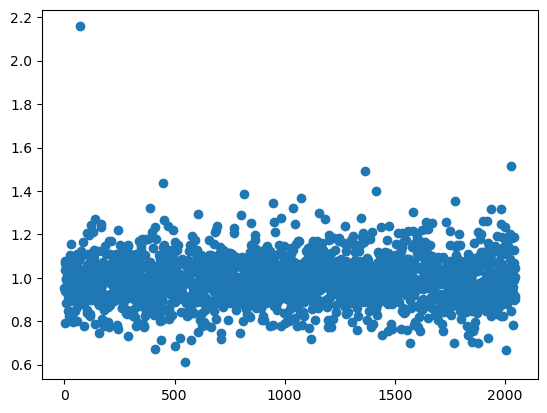

In [80]:
tab_mean_positive = np.zeros(num_feature)
tab_mean_negative = np.zeros(num_feature)
tab_mean_diff = np.zeros(num_feature)

tab_std_positive = np.zeros(num_feature)
tab_std_negative = np.zeros(num_feature)

for feature in range(num_feature):
    tab_mean_positive[feature] = X_positive_train_max_flat[:,feature].mean()
    tab_mean_negative[feature] = X_negative_train_max_flat[:,feature].mean()
    tab_mean_diff[feature] = tab_mean_positive[feature]/tab_mean_negative[feature]

    tab_std_positive[feature] = X_positive_train_max_flat[:,feature].std()
    tab_std_negative[feature] = X_negative_train_max_flat[:,feature].std()



plt.scatter(range(num_feature), tab_mean_diff)
plt.show()

In [91]:
X_positive_train_max_flat[:,72].mean()

0.011505795

In [92]:
X_negative_train_max_flat[:,72].mean()

0.0053328983

In [93]:
X_positive_train_max_flat[:,72].mean()

0.4131661

In [94]:
X_positive_train_max_flat[:,72].mean()

0.011505795

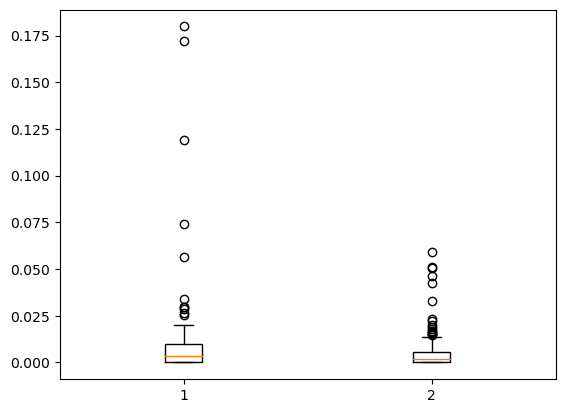

In [89]:
plt.boxplot([X_positive_train_max_flat[:,72], X_negative_train_max_flat[:,72]])
plt.show()

[]

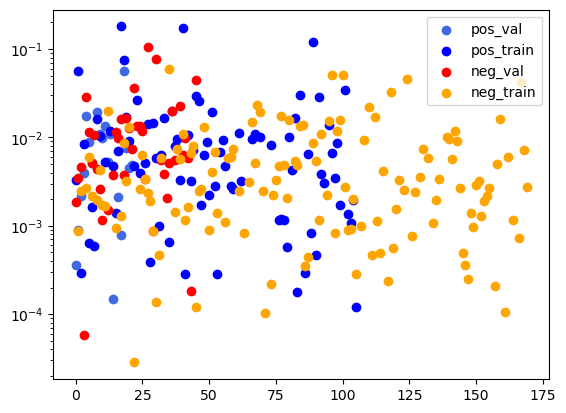

In [110]:
plt.scatter(range(len(X_positive_val_max_flat[:,72])), X_positive_val_max_flat[:,72], label = "pos_val", c="royalblue")
plt.scatter(range(len(X_positive_train_max_flat[:,72])), X_positive_train_max_flat[:,72], label = "pos_train", c="b")
plt.scatter(range(len(X_negative_val_max_flat[:,72])),X_negative_val_max_flat[:,72], label = "neg_val", c="red")
plt.scatter(range(len(X_negative_train_max_flat[:,72])),X_negative_train_max_flat[:,72], label = "neg_train", c="orange")
plt.legend()
plt.yscale("log")
plt.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x269f31ded00>,
 'caps': [<matplotlib.lines.Line2D at 0x269f31eb2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x269f31deb50>],
 'medians': [<matplotlib.lines.Line2D at 0x269f31eb880>],
 'fliers': [<matplotlib.lines.Line2D at 0x269f31ebb50>],
 'means': []}

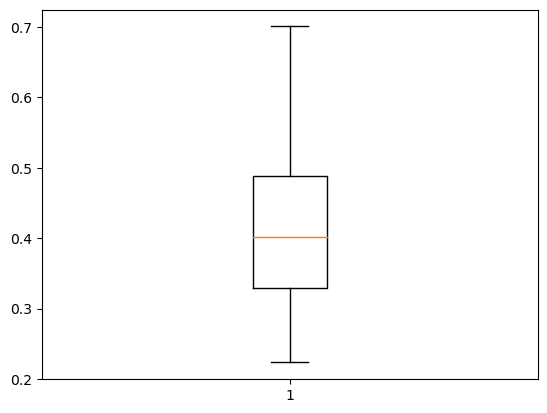

In [83]:
plt.boxplot(X_positive_train_max_flat[:,0])

In [71]:
tab_mean_diff.argmax()

72

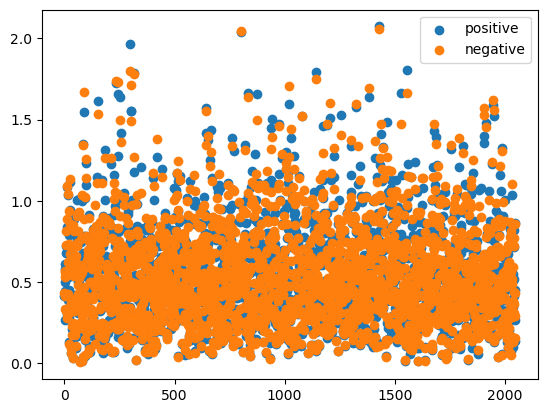

In [63]:
plt.scatter(range(num_feature), tab_mean_positive, label = "positive")
plt.scatter(range(num_feature), tab_mean_negative, label = "negative")
plt.legend()
plt.show()

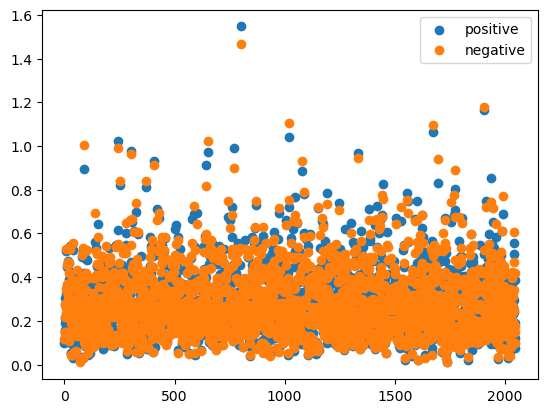

In [64]:
plt.scatter(range(num_feature), tab_std_positive, label = "positive")
plt.scatter(range(num_feature), tab_std_negative, label = "negative")
plt.legend()
plt.show()

In [17]:
from sklearn.decomposition import PCA

In [18]:
from sklearn.feature_selection import SelectKBest

In [20]:
y_train_flat = np.zeros((y_train.shape[0], 1000))
for i in range(y_train.shape[0]):
    y_train_flat[i] = np.ones(1000) * y_train[i]

y_train_flat = y_train_flat.flatten()

In [22]:
k = 10

In [23]:
select_k_best = SelectKBest(k=k)

In [24]:
select_k_best.fit(X_train_flat, y_train_flat)

SelectKBest()

In [74]:
select_k_best.pvalues_.shape

(2048,)

In [25]:
X_train_flat_k_best = select_k_best.transform(X_train_flat)

In [26]:
X_positive_train_flat_k_best = X_train_flat_k_best[y_train_flat == 1]
X_negative_train_flat_k_best = X_train_flat_k_best[y_train_flat == 0]

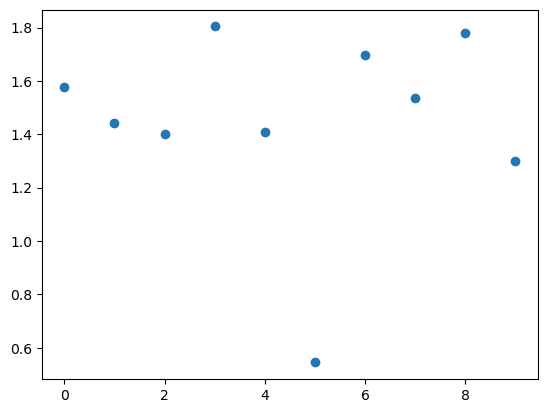

In [79]:
tab_mean_positive = np.zeros(k)
tab_mean_negative = np.zeros(k)
tab_mean_diff = np.zeros(k)

tab_std_positive = np.zeros(k)
tab_std_negative = np.zeros(k)

for feature in range(k):
    tab_mean_positive[feature] = X_positive_train_flat_k_best[:,feature].mean()
    tab_mean_negative[feature] = X_negative_train_flat_k_best[:,feature].mean()
    tab_mean_diff[feature] = tab_mean_positive[feature]/tab_mean_negative[feature]

    tab_std_positive[feature] = X_positive_train_flat_k_best[:,feature].std()
    tab_std_negative[feature] = X_negative_train_flat_k_best[:,feature].std()



plt.scatter(range(k), tab_mean_diff)
plt.show()

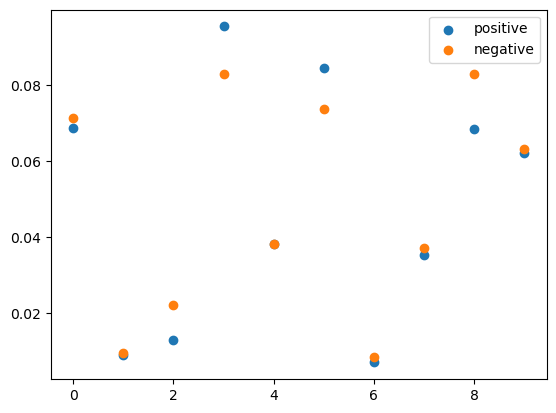

In [28]:
plt.scatter(range(k), tab_mean_positive_k_best, label = "positive")
plt.scatter(range(k), tab_mean_negative_k_best, label = "negative")
plt.legend()
plt.show()

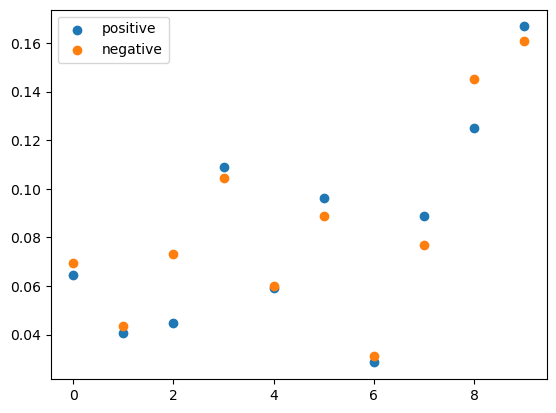

In [29]:
plt.scatter(range(k), tab_std_positive_k_best, label = "positive")
plt.scatter(range(k), tab_std_negative_k_best, label = "negative")
plt.legend()
plt.show()

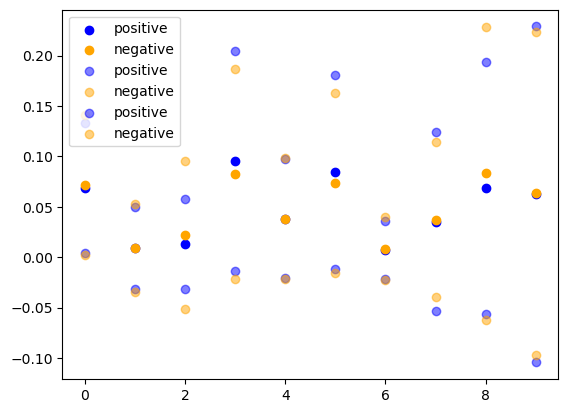

In [30]:
plt.scatter(range(k), tab_mean_positive_k_best, label = "positive", c="b")
plt.scatter(range(k), tab_mean_negative_k_best, label = "negative", c="orange")

plt.scatter(range(k), tab_mean_positive_k_best + tab_std_positive_k_best, label = "positive", c="b", alpha=0.5)
plt.scatter(range(k), tab_mean_negative_k_best + tab_std_negative_k_best, label = "negative", c="orange", alpha=0.5)

plt.scatter(range(k), tab_mean_positive_k_best - tab_std_positive_k_best, label = "positive", c="b", alpha=0.5)
plt.scatter(range(k), tab_mean_negative_k_best - tab_std_negative_k_best, label = "negative", c="orange", alpha=0.5)

plt.legend()
plt.show()

In [31]:
svm = SVM(C=1, kernel="poly")

In [37]:
X_train_mean_k_best = select_k_best.transform(X_train_mean)

In [41]:
X_val_mean_k_best = select_k_best.transform(X_val_mean)

In [ ]:
X_val_k_best = select_k_best.transform(X_val)

In [47]:
X_val.shape

(68, 1000, 2048)

In [40]:
svm.svm.fit(X_train_mean_k_best, y_train)

SVC(C=1, kernel='poly', probability=True)

In [42]:
val_pred = svm(X_val_mean_k_best)

In [43]:
roc_auc_score(y_val, val_pred)

0.6358695652173914

In [54]:
list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
list_C = [1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3, 1e4]

In [55]:
mono_res = {}
smooth_max_res = {}
max_res = {}

In [56]:
for kernel in list_kernel:
    mono_res[kernel] = dict()
    smooth_max_res[kernel] = dict()
    max_res[kernel] = dict()
    for C in list_C:    
        mono_model = SVM(C=C, kernel=kernel)
        mono_model.svm.fit(X_train_mean_k_best, y_train)

        mono_val_pred = mono_model(X_val_mean_k_best)

        mono_res[kernel][C] = roc_auc_score(y_val, mono_val_pred)
#        print(f"kernel={kernel.ljust(7)}, C={'{:.0e}'.format(C)}, mono_val_score = {'{:.3f}'.format(roc_auc_score(y_val, mono_val_pred))}, val_score={'{:.3f}'.format(roc_auc_score(y_val, val_pred))}")

[]

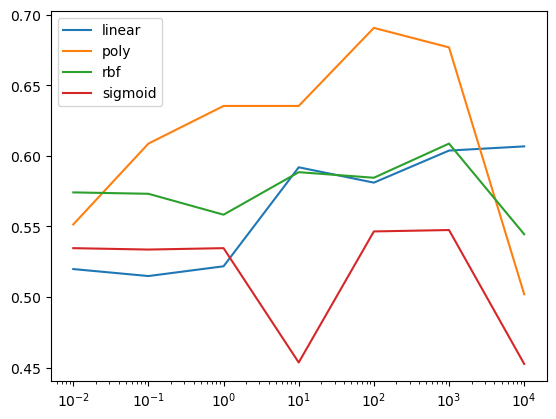

In [57]:
for kernel in list_kernel:
    plt.plot(list(mono_res[kernel].keys()), list(mono_res[kernel].values()), label = kernel)
plt.xscale('log')
plt.legend()
plt.plot()

In [59]:
list_degree = [2,3,4,5,6]

In [60]:
for degree in list_degree:
    mono_res[degree] = dict()
    smooth_max_res[degree] = dict()
    max_res[degree] = dict()
    for C in list_C:    
        mono_model = SVM(C=C, kernel="poly", degree=degree)
        mono_model.svm.fit(X_train_mean_k_best, y_train)

        mono_val_pred = mono_model(X_val_mean_k_best)

        mono_res[degree][C] = roc_auc_score(y_val, mono_val_pred)
#        print(f"kernel={kernel.ljust(7)}, C={'{:.0e}'.format(C)}, mono_val_score = {'{:.3f}'.format(roc_auc_score(y_val, mono_val_pred))}, val_score={'{:.3f}'.format(roc_auc_score(y_val, val_pred))}")

[]

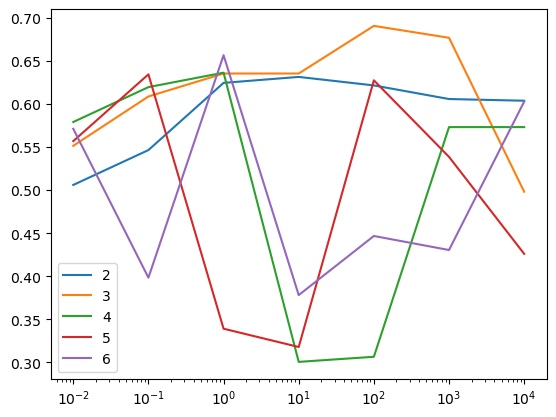

In [61]:
for degree in list_degree:
    plt.plot(list(mono_res[degree].keys()), list(mono_res[degree].values()), label = degree)
plt.xscale('log')
plt.legend()
plt.plot()